## Preparations with Pandas

### Importing required packages

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

### Loading the data

In [95]:
df = pd.read_csv("JAPAN_EMSC.csv")

### Making index to start from No.1

In [96]:
df = df.reset_index(drop=True)
df.index = range(1, len(df)+1)

### Shape

In [97]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns")

There are 128 rows and 7 columns


### Type of data 

In [98]:
df.dtypes

date_time_UTC       object
latitude_deg       float64
longitude_deg      float64
depth_km             int64
magnitude_value    float64
magnitude_type      object
region              object
dtype: object

### Converting data type of numerical columns to float 

In [99]:
df["depth_km"] = df["depth_km"].astype("float")

### Converting data type of date_time column to datetime

In [100]:
df["date_time_UTC"] = pd.to_datetime(df["date_time_UTC"], format="%Y-%m-%d %H:%M:%S")

### Spotting NaN

In [101]:
df.isna().sum()

date_time_UTC      0
latitude_deg       0
longitude_deg      0
depth_km           0
magnitude_value    0
magnitude_type     0
region             0
dtype: int64

### Removing duplicates

In [102]:
rows0 , col0 = df.shape
df = df.drop_duplicates()
rows1 , col1 = df.shape

print(f"There were {rows1 - rows0} duplicates rows that were removed")

There were 0 duplicates rows that were removed


### Spotting & Removing events happened outside Japan 

#### Spotting events happened outside Japan

In [103]:
# print(df)
def spot_loation(value):
    if not "JAPAN" in value:
        value = "outside Japan"
    return value

df["region"] = df["region"].apply(spot_loation)

not_japan = (df["region"]=="outside Japan").sum()
print(f"Out of {df.shape[0]} records, {not_japan} of them aren't related to Japan")   

Out of 128 records, 8 of them aren't related to Japan


In [104]:
x = df[df["region"]=="outside Japan"]
print(x["region"])

21     outside Japan
38     outside Japan
63     outside Japan
68     outside Japan
70     outside Japan
76     outside Japan
125    outside Japan
126    outside Japan
Name: region, dtype: object


#### Removing events happened outside Japan

In [105]:
df = df[df["region"]!="outside Japan"]
df.shape

(120, 7)

### Adding a new column: Month

In [106]:
df.insert(1, "Month", value= df["date_time_UTC"].apply(lambda x: calendar.month_name[x.month]))

### Adding a new column: Category

In [107]:
def classify_mag(value):
    if value < 4:
        return "weak"
    elif 4 <= value <= 6:
        return "moderate"
    else:
        return "strong"
        
x = df["magnitude_value"].apply(classify_mag)
df.insert(7, "Category", value = x)

### Changing the name of column 'region' to 'place'

In [108]:
df = df.rename(columns={"region":"place"})

### Defining a new column: Region

In [109]:
def f(x):
    x = x.split(",")
    return x[0]

df["region"] = df["place"].apply(f)

## Analysis with Pandas

### Total & average number of earthquakes based on Month & Category

In [110]:
month_categ_stats = df.groupby(["Month","Category"]).agg(avg_magnitude=("magnitude_value", "mean"), earthquake_count=("magnitude_value", "count")).reset_index()
month_categ_stats["avg_magnitude"] = month_categ_stats["avg_magnitude"].round(2)
month_categ_stats.index = range(1, len(month_categ_stats)+1)
print(month_categ_stats)

       Month  Category  avg_magnitude  earthquake_count
1    October  moderate           4.57                27
2    October      weak           3.31                23
3  September  moderate           4.41                29
4  September      weak           3.33                41


### Grouping by data based on region & doing relevant analysis

#### Count of earthquakes per region

In [111]:
print(df.groupby("region").size().sort_values(ascending=False))

region
RYUKYU ISLANDS               34
NEAR EAST COAST OF HONSHU    27
OFF EAST COAST OF HONSHU     14
HOKKAIDO                      7
EASTERN HONSHU                6
KYUSHU                        6
BONIN ISLANDS                 5
NEAR S. COAST OF HONSHU       5
NEAR WEST COAST OF HONSHU     5
IZU ISLANDS                   4
WESTERN HONSHU                3
SHIKOKU                       2
SOUTHWESTERN RYUKYU ISL.      2
dtype: int64


#### Average of magnitude and depth of earthquakes per region

In [112]:
print(df.groupby("region").agg({"magnitude_value":"mean", "depth_km":"mean"}).round(2))

                           magnitude_value  depth_km
region                                              
BONIN ISLANDS                         4.10    435.60
EASTERN HONSHU                        3.25     35.00
HOKKAIDO                              3.69     60.71
IZU ISLANDS                           4.47    295.25
KYUSHU                                3.40     21.67
NEAR EAST COAST OF HONSHU             4.10     49.19
NEAR S. COAST OF HONSHU               3.70     54.00
NEAR WEST COAST OF HONSHU             3.84     44.00
OFF EAST COAST OF HONSHU              4.62      9.07
RYUKYU ISLANDS                        3.61     14.21
SHIKOKU                               3.30     40.00
SOUTHWESTERN RYUKYU ISL.              4.00     52.50
WESTERN HONSHU                        3.17     13.33


#### Maximum of magnitude and depth of earthquakes per region

In [113]:
print(df.groupby("region").agg({"magnitude_value":"max", "depth_km":"max"}).round(2))

                           magnitude_value  depth_km
region                                              
BONIN ISLANDS                          4.2     504.0
EASTERN HONSHU                         3.8      60.0
HOKKAIDO                               4.3     130.0
IZU ISLANDS                            4.8     437.0
KYUSHU                                 4.1      30.0
NEAR EAST COAST OF HONSHU              6.0     100.0
NEAR S. COAST OF HONSHU                4.5     110.0
NEAR WEST COAST OF HONSHU              4.6     180.0
OFF EAST COAST OF HONSHU               4.9      12.0
RYUKYU ISLANDS                         5.3     140.0
SHIKOKU                                3.5      40.0
SOUTHWESTERN RYUKYU ISL.               4.5      55.0
WESTERN HONSHU                         3.3      20.0


### Bar chart for count of earthquakes per region

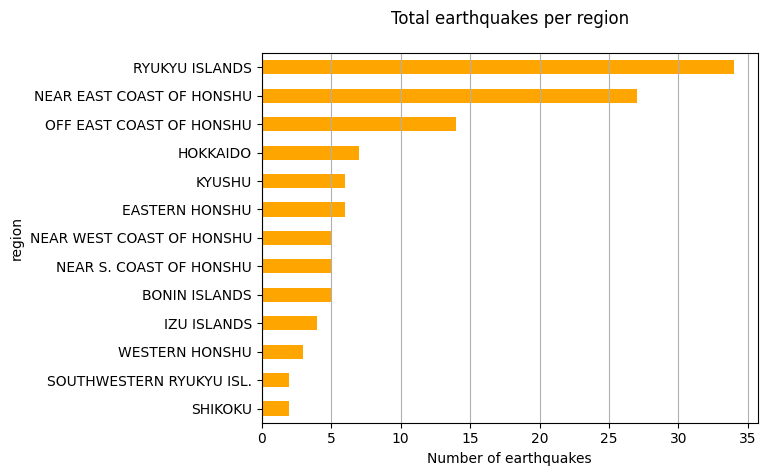

In [114]:
m = df.groupby("region").size().sort_values()
region_plot = m.plot(kind="barh", color="orange")
region_plot.set_xlabel("Number of earthquakes")
# m.set_ylabel("Region")
region_plot.set_title("Total earthquakes per region\n")
# region_plot.grid(True)
region_plot.grid(axis='x')

## Numpy Analysis

### Part1: Calculating Distance from Tokyo

#### Latitude & Longitude for Tokyo, Japan

In [115]:
tokyo_latitude, tokyo_longitude  = 35.6764, 139.6500

#### Distance calculations

In [116]:
# distance = np.sqrt(
# (df["latitude_deg"] - tokyo_latitude)**2 +
# (df["longitude_deg"] - tokyo_longitude)**2  
# ).round(2)

# df.insert(4, "dist_to_Tokyo_km", value=distance)

#################### OR

#convert degrees to radians to be able to use them with np.sin(), np.cos() & np.arcsin()
earthquake_lat = np.radians(df["latitude_deg"])
earthquake_lng = np.radians(df["longitude_deg"])
tokyo_lat = np.radians(tokyo_latitude)
tokyo_lng = np.radians(tokyo_longitude)

dlat = earthquake_lat - tokyo_lat
dlng = earthquake_lng - tokyo_lng

a = np.sin(dlat / 2)**2 + np.cos(earthquake_lat) * np.cos(tokyo_lat) * np.sin(dlng / 2)**2
c = 2 * np.arcsin(np.sqrt(a))

# Radius of Earth in km = 6371.00
distance = (c * 6371).round(2)
df.insert(4, "dist_to_Tokyo_km", value=distance)

### Part2: Earthquake Magnitude Analysis

#### Date Range for this Analysis

In [117]:
start_date = df.iloc[-1,0]
start_date = str(start_date).split()[0]
end_date = df.iloc[0,0]
end_date = str(end_date).split()[0]
print(f"From {start_date} to {end_date}")

From 2025-09-15 to 2025-10-14


#### Earthquake Magnitude Average

In [118]:
mag_average = np.mean(df["magnitude_value"])
print(f"Average magnitude for earthquakes from {start_date} to {end_date} was {mag_average:.2f}")

Average magnitude for earthquakes from 2025-09-15 to 2025-10-14 was 3.87


#### Earthquake Magnitude Variance & Standard Deviation

In [119]:
mag_std_dev = np.std(df["magnitude_value"])
mag_var = mag_std_dev ** 2
print(f"Variance of magnitude for earthquakes from {start_date} to {end_date} was {mag_var:.2f}")
print(f"Standard deviation of magnitude for earthquakes from {start_date} to {end_date} was {mag_std_dev:.2f}")

Variance of magnitude for earthquakes from 2025-09-15 to 2025-10-14 was 0.44
Standard deviation of magnitude for earthquakes from 2025-09-15 to 2025-10-14 was 0.67


#### Earthquake Magnitude Percentile

In [120]:
mag_p25 = np.percentile(df["magnitude_value"], 25)
mag_p50 = np.percentile(df["magnitude_value"], 50)
mag_p75 = np.percentile(df["magnitude_value"], 75)
print(f"From {start_date} to {end_date} magnitude for:")
print(f"25% of earthquakes was equal or less than {mag_p25:.2f}")
print(f"50% of earthquakes was equal or less than {mag_p50:.2f}")
print(f"75% of earthquakes was equal or less than {mag_p75:.2f}")

From 2025-09-15 to 2025-10-14 magnitude for:
25% of earthquakes was equal or less than 3.30
50% of earthquakes was equal or less than 3.80
75% of earthquakes was equal or less than 4.50


## Exporting cleaned data 

In [122]:
df.to_csv('JAPAN_EMSC_cleaned.csv' , encoding='utf-8-sig', index=False)